## test for overtraining
1. split data to use overfitting/underfitting

2. get accuracy score for ytest and xtest

3. plot both accuracies by changing 1 parameter


[siehe hier](https://youtu.be/AvWfL1Us3Kg?t=263)

In [1]:
import numpy as np
import pandas as pd
from functions import load_parquet

df = load_parquet("/ceph/aavocone/Datasets/3_large.parquet")

df.drop(["class","cladd"], axis=1, inplace=True)
print(df.columns)


ModuleNotFoundError: No module named 'functions'

### train_test_split oversample 

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split



x = df[df.columns[:-1]]
y = df["signal"]
xtrain,xval,ytrain,yval = train_test_split(x, y, test_size = 0.33, stratify = y)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain, ytrain, test_size = 0.5, stratify= ytrain)

over_sample = RandomOverSampler(sampling_strategy = 0.2)
xtrain, ytrain = over_sample.fit_resample(xtrain,ytrain)
xtest, ytest = over_sample.fit_resample(xtest,ytest)
xval, yval = over_sample.fit_resample(xval,yval)

print("Length training set:             ",len(ytrain))
print("Number of signals in training:   ",sum(ytrain))
print("Length testing set:              ",len(ytest))
print("Number of signals in testing:    ",sum(ytest))
print("Length validation set:           ",len(yval))
print("Number of signals in validation: ",sum(yval))

Length training set:              55884543
Number of signals in training:    9314090.0
Length testing set:               55884543
Number of signals in testing:     9314090.0
Length validation set:            55050446
Number of signals in validation:  9175074.0


### train_test_split undersample


In [4]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
from functions import load_parquet

df = load_parquet("/ceph/aavocone/Datasets/3_large.parquet")

x = df[df.columns[:-1]]
y = df["signal"]

under_sample = RandomUnderSampler(sampling_strategy = 0.2)
xunder, yunder = under_sample.fit_resample(x,y)

print("Length undersampled set:     ",len(xunder))
print("Number of signals :          ",sum(yunder))

Index(['B_sig_K_dr', 'B_sig_K_dz', 'B_sig_CleoConeCS_3_ROE',
       'thrustAxisCosTheta', 'aplanarity', 'sphericity',
       'harmonicMomentThrust0', 'harmonicMomentThrust1',
       'harmonicMomentThrust2', 'harmonicMomentThrust3',
       'harmonicMomentThrust4', 'foxWolframR1', 'foxWolframR2', 'foxWolframR3',
       'foxWolframR4', 'signal', 'class', 'cladd'],
      dtype='object')


!!!!!!!! Remove the class and cladd column !!!!!!!
Index(['B_sig_K_dr', 'B_sig_K_dz', 'B_sig_CleoConeCS_3_ROE',
       'thrustAxisCosTheta', 'aplanarity', 'sphericity',
       'harmonicMomentThrust0', 'harmonicMomentThrust1',
       'harmonicMomentThrust2', 'harmonicMomentThrust3',
       'harmonicMomentThrust4', 'foxWolframR1', 'foxWolframR2', 'foxWolframR3',
       'foxWolframR4', 'signal'],
      dtype='object')
Length undersampled set:      120402
Number of signals :           20067.0


# ROC curve comparion
Testing ROC curve on an oversampled test set to get a bigger difference between the plots

/work/aavocone/anaconda3/envs/Bachelor/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


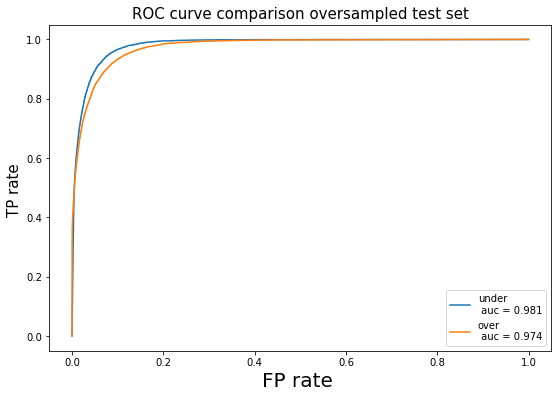

In [1]:
import numpy as np
import pandas as pd
from functions import load_parquet
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

df = load_parquet("/ceph/aavocone/Datasets/3_large.parquet")

x = df[df.columns[:-1]]
y = df["signal"]

xtrain,xval,ytrain,yval = train_test_split(x, y, test_size = 0.33, stratify = y)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain, ytrain, test_size = 0.5, stratify= ytrain)
over_sample = RandomOverSampler(sampling_strategy = 0.2)
xtest, ytest = over_sample.fit_resample(xtest,ytest)


weight = (len(ytrain)-sum(ytrain))/sum(ytrain)

model_over = XGBClassifier()
model_over.load_model("/work/aavocone/models/over_mA3_1000.txt")
y_over = model_over.predict_proba(xtest)[:,1]
#n=_over
auc_over =roc_auc_score(ytest,y_over)
fp_over,tp_over, thresh_over = roc_curve(ytest, y_over)




model_under = XGBClassifier()
model_under.load_model("/work/aavocone/models/under_mA3_1000.txt")
y_under = model_under.predict_proba(xtest)[:,1]


#n=_under
auc_under =roc_auc_score(ytest,y_under)
fp_under,tp_under, thresh_under = roc_curve(ytest, y_under)

plt.figure(figsize=(9,6))
plt.plot(fp_under, tp_under, label = f"under\n auc = {auc_under:.3f}")
plt.plot(fp_over, tp_over, label = f"over\n auc = {auc_over:.3f}")
plt.title(f"ROC curve comparison oversampled test set", fontsize = 15)
plt.xlabel("FP rate ", fontsize = 20)
plt.ylabel("TP rate ", fontsize = 15)
plt.legend()
plt.savefig(f"/work/aavocone/week10/ROC_over_under.jpeg")
plt.show()